In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(r"D:\data_sets\SST\GBR\gbr_sst_avg.csv")

In [ ]:
from mypro

tmp_ds['anom_clim'] = calc_anom(tmp_ds['raw'], mode='climatological')

In [3]:
temp = data['sst'].to_numpy()
ix = np.arange(temp.size)

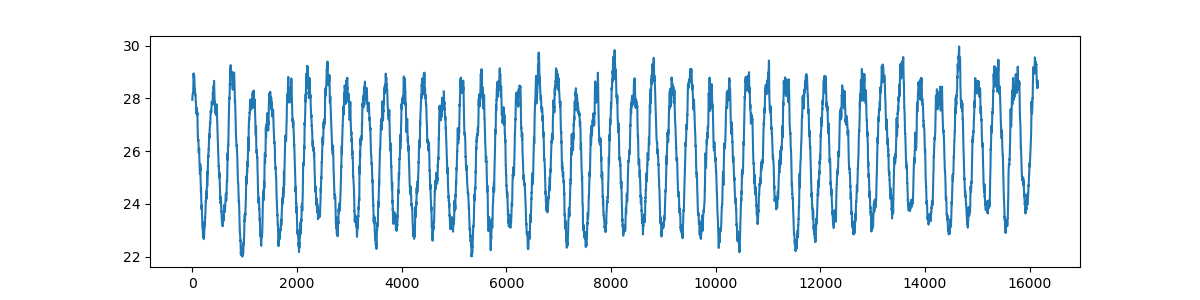

In [4]:
%matplotlib widget
plt.figure(figsize=(12, 3))
plt.plot(ix, temp)
plt.show()

In [5]:
dtemp = np.diff(temp)

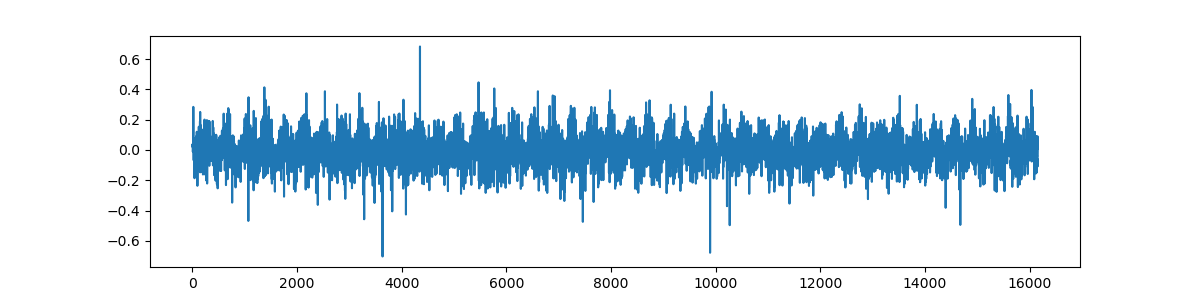

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(ix[1:], dtemp) 
plt.show()

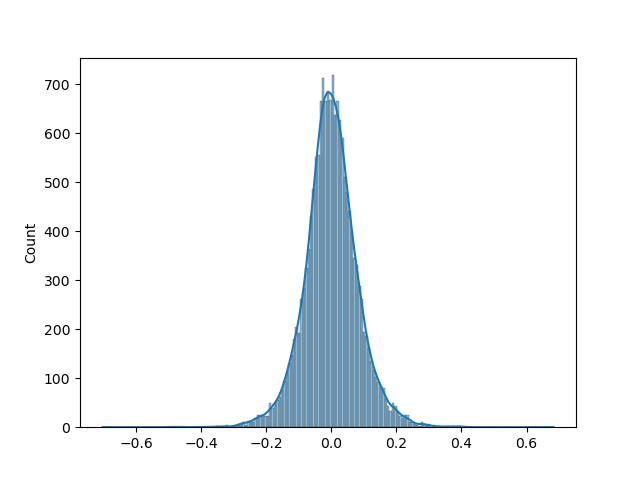

mean=0.000029, stdev=0.081811


In [7]:
plt.figure()
sb.histplot(dtemp, kde=True)
plt.show()
print(f"mean={dtemp.mean():.6f}, stdev={dtemp.std():.6f}")

# Model

$$
\text{Parameters}: T_i, ~ 0 \leq i < n ~ \dots ~ \text{True temperature}
\\
\text{Measurements}: M_i, ~ 0 \leq i < n ~ \dots ~ \text{Measured temperature}
\\
\text{Measurement model}: M_i = T_i + \epsilon_i, ~~ \epsilon_i \sim N(0, \sigma_M)
\\
\text{Prior (Random Walk)}: T_i - T_{i-1} = \nu_i, ~~ \nu_i \sim N(0, \sigma_T)
$$

Under the above massumptions (linear model, normally distributed errors), the Bayesian inference problem simplifies to a least squares problem of the form
$$
y = Ax + e
$$
with,  
$y = \{M_1, \dots, M_n, 0, \dots, 0\}$,  
$e = \{\epsilon_1, \dots, \epsilon_n, \nu_1, \dots, \nu_n\}$ and
$$
A = \begin{pmatrix}
1 & 0 & 0 & \dots \\
0 & 1 & 0 & \dots \\
0 & 0 & 1 & \dots \\
\vdots & \vdots & \vdots & \vdots \\
-1 & 1 & 0 & \dots \\
0 & -1 & 1 & \dots \\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}.
$$

In [8]:
from scipy.sparse import coo_array, dok_array, eye_array, diags_array, vstack
from scipy.sparse.linalg import spsolve, inv

In [9]:
sigma_m = 0.1
sigma_t = 0.081

In [10]:
n = temp.size
y = np.r_[temp/sigma_m, np.zeros(n)]
A = dok_array((2*n, n-1))
A1 = eye_array(n) / sigma_m # standardize
A2 = diags_array([np.r_[0, np.ones(n-1)], -np.ones(n-1)], offsets=[0, -1]) / sigma_t # standardize
A = vstack([A1, A2])

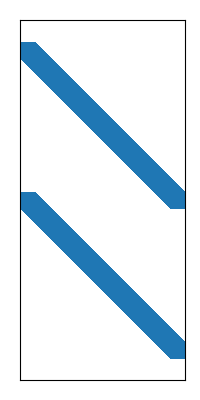

In [11]:
plt.figure(figsize=(2, 4))
plt.spy(A)
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.tight_layout()
plt.show()

In [12]:
C = inv(A.T@A)

/home/fpoeppl/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/fpoeppl/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [13]:
x = C @ (A.T@y)

In [14]:
# plt.figure(figsize=(2, 2))
# plt.spy(C)
# plt.xticks([])
# plt.yticks([])
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

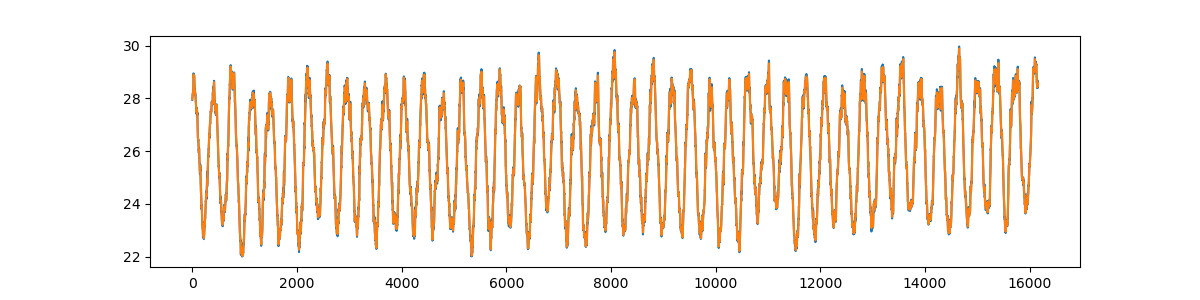

In [15]:
%matplotlib widget
plt.figure(figsize=(12, 3))
plt.plot(ix, temp)
plt.plot(ix, x)
plt.show()

## Get probability of temperature above threshold

The covariance matrix gets us the joint distribution, then simply use the respective joint CDF to obtain the probabilities.
Definition of CDF (from wikipedia):
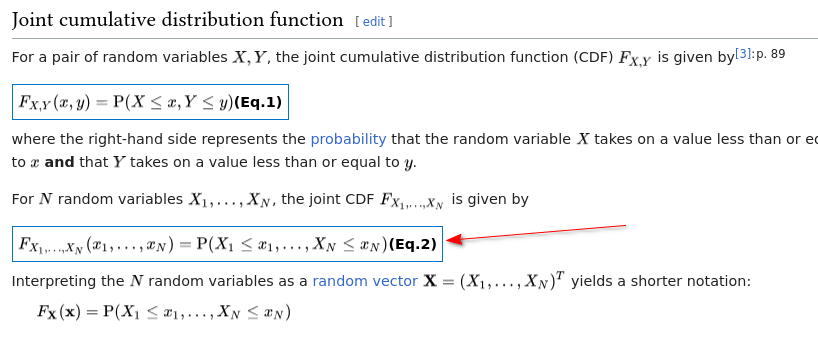

In [16]:
from scipy.stats import multivariate_normal
def above_threshold_probability(start, count, threshold):
    m_ = x[start:start+count]
    C_ = C[start:start+count, start:start+count].todense()
    # get probability p(t_i >= T, t_{i+1} >+ T, ... | M) from posterior CDF
    N =  multivariate_normal(m_, C_)
    # this controls the numerical accuracy (default values are slow....)
    N.maxpts = 10000
    N.abseps = 1e-4
    N.releps = 1e-4
    return N.cdf(np.ones(count)*np.inf, lower_limit=np.ones(count)*threshold)

In [17]:
threshold = 29.0
count = 30

In [18]:
ix_ = []
pct_above = []
all_above = []
increment = 1
for i in np.arange(0, n, increment)[:-count]:
    ix_.append(i)
    pct_above.append(
        above_threshold_probability(
            start=i, count=count, threshold=threshold))
    all_above.append(np.all(x[i:i+count] >= threshold))
    print(f" {i/n*100:.2f} %", end='\r')
print(f"100 %")
ix_ = np.array(ix_)
pct_above = np.array(pct_above)
all_above = np.array(all_above)

100 %1 %


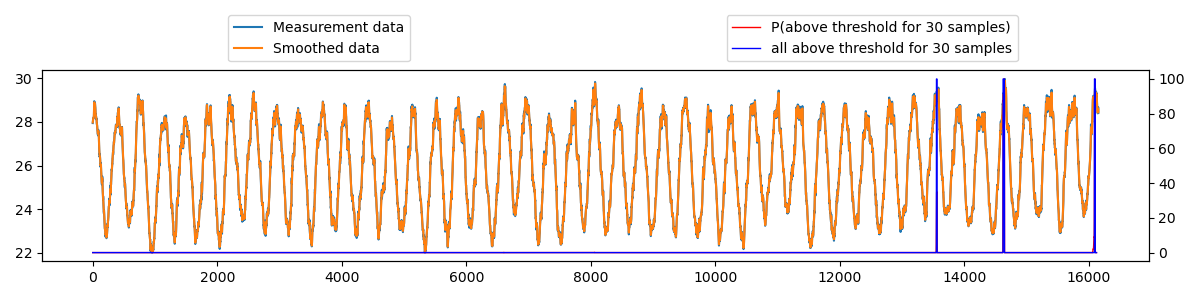

In [19]:
%matplotlib widget
plt.figure(figsize=(12, 3))
plt.plot(ix, temp, label="Measurement data")
plt.plot(ix, x, label="Smoothed data")
plt.legend(bbox_to_anchor=(0.25, 1.01), loc=8)
ax = plt.gca().twinx()
plt.plot(ix_, pct_above*100, color='red', linewidth=1, label="P(above threshold for 30 samples)")
plt.plot(ix_, all_above*100, color='blue', linewidth=1, label="all above threshold for 30 samples")
plt.legend(bbox_to_anchor=(0.75, 1.01), loc=8)
plt.tight_layout()
plt.show()